In [2]:
using FileIO
using CSV
using DataFrames
using LinearAlgebra
using Statistics
using Glob
using Parameters

using Plots
using PGFPlots


In [3]:
pgfplots()

Plots.PGFPlotsBackend()

In [4]:
@with_kw mutable struct ScenarioResult 
    filename::String = "filename"
    algorithm::String = "algorithm"
    policy::String = "policy"
    collision_cost::Float64 = 0.
    probability_pedestrian_birth::Float64 = 0.
    action_lon_cost::Float64 = 0.
    action_lat_cost::Float64 = 0.
    keep_velocity_reward::Float64 = 0.
    keep_lane_reward::Float64 = 0.
    
    sum_scenarios::Int = 0
    sum_collisions::Int = 0
    sum_emergency_brake_interventions::Int = 0
    dv::Float64 = 0.
    v_mean::Float64 = 0.
    a_mean::Float64 = 0.
    a_jerk::Float64 = 0.
    a_min::Float64 = 0.
end

function readResults(folder_name)

    current_path = pwd()
    results = []
    try
        cd(folder_name)
        files = glob(string("results_", folder_name, "*.csv" ))
        results = []
        for file_name in files
            result = evaluate_file(file_name) 
            push!(results, result)
        end

    catch
    end

    cd(current_path)
    return results
end

function evaluate_file(filename)
    
    result = ScenarioResult()
    result.filename = filename
    file_name_parameters = split(filename,'_')
    collision_cost = 0.
    probability_pedestrian_birth = 0.
    action_lon_cost = 0.
    action_lat_cost = 0.
    keep_velocity_reward = 0.
    if ( file_name_parameters[2] != "EmergencyBrakingSystem")    
        if ( file_name_parameters[3] == "EmergencyBrakingSystem")
            result.algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem" 
            result.policy = file_name_parameters[4]
            result.collision_cost = parse(Float64, file_name_parameters[5])
            result.probability_pedestrian_birth = parse(Float64, file_name_parameters[6])
            result.action_lon_cost = parse(Float64, file_name_parameters[7])
            result.action_lat_cost = parse(Float64, file_name_parameters[8])
            result.keep_velocity_reward = parse(Float64, file_name_parameters[9])
            try
                result.keep_lane_reward = parse(Float64, file_name_parameters[10])
            catch
                
            end
        else
            result.algorithm = "PedestrianAvoidancePOMDP" 
            result.policy = file_name_parameters[3]
            result.collision_cost = parse(Float64, file_name_parameters[4])
            result.probability_pedestrian_birth = parse(Float64, file_name_parameters[5])
            result.action_lon_cost = parse(Float64, file_name_parameters[6])
            result.action_lat_cost = parse(Float64, file_name_parameters[7])
            result.keep_velocity_reward = parse(Float64, file_name_parameters[8])
            try
                result.keep_lane_reward = parse(Float64, file_name_parameters[9])
            catch
                
            end
        end
    else
        result.algorithm = "EmergencyBrakingSystem" 
    end

    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []

    for row in CSV.File(filename)
        push!(dv, row.dv_collision)
        push!(v_mean, row.v_mean)
        push!(a_mean, row.a_mean)
        push!(a_jerk, row.a_jerk)
        push!(a_min, row.a_min)
        result.sum_collisions += row.collision
        result.sum_emergency_brake_interventions += row.eb_intervention
        result.sum_scenarios += 1
    end

    result.dv = mean(dv)
    result.v_mean = mean(v_mean)
    result.a_mean = mean(a_mean)
    result.a_jerk = mean(a_jerk)
    result.a_min = mean(a_min)

    return result
end

evaluate_file (generic function with 1 method)

In [5]:
# get results from Emergency Braking System

files = glob("results_EmergencyBrakingSystem_*.csv")
results_ermergency_system = []
for file_name in files
    result = evaluate_file(file_name) 
    push!(results_ermergency_system, result)
    println(result)
end

ScenarioResult
  filename: String "results_EmergencyBrakingSystem_no.jld2.csv"
  algorithm: String "EmergencyBrakingSystem"
  policy: String "policy"
  collision_cost: Float64 0.0
  probability_pedestrian_birth: Float64 0.0
  action_lon_cost: Float64 0.0
  action_lat_cost: Float64 0.0
  keep_velocity_reward: Float64 0.0
  keep_lane_reward: Float64 0.0
  sum_scenarios: Int64 26
  sum_collisions: Int64 3
  sum_emergency_brake_interventions: Int64 24
  dv: Float64 1.1121794871794872
  v_mean: Float64 12.095090684754608
  a_mean: Float64 -8.655748098055792
  a_jerk: Float64 17.307692307692307
  a_min: Float64 -9.23076923076923



In [76]:


function generateRewardPlots(folder_name, probability_pedestrian_births)
    
    actionloncost = [0., -1., -2., -5.]
    keepvelocityreward = [0., 10., 20., 30., 40.]

    results = readResults(folder_name)


    plots_vmean = PGFPlots.Axis[]
    plots_collision = PGFPlots.Axis[] 
    plots_interventions = PGFPlots.Axis[] 

    cnt = 0
    for probability_pedestrian_birth in probability_pedestrian_births
        println("ped-p: ", probability_pedestrian_birth)
        cnt = cnt + 1

        # find relevant configurations
        id_matrix = zeros(Int64, length(actionloncost), length(keepvelocityreward))
        for i=1:length(results)
            result = results[i]
            if result.probability_pedestrian_birth == probability_pedestrian_birth
                id_action_lon_cost = findall(x->x == result.action_lon_cost, actionloncost)
                id_keep_velocity_reward = findall(x->x == result.keep_velocity_reward, keepvelocityreward )
                id_matrix[id_action_lon_cost[1],id_keep_velocity_reward[1]] = i 
            end
        end
        #println(id_matrix)




        x_label = "Penalty longitudinal action [-]"
        visualize_legend = true
        title_v_mean = string("Pedestrian appearance: ", probability_pedestrian_birth)
        if ( occursin("EmergencyBrakingSystem", results[1].algorithm) )
            x_label = ""
            visualize_legend = false
            title_v_mean = string("Pedestrian appearance: ", probability_pedestrian_birth)

        end


        if ( cnt == 1)
            plot_vmean = PGFPlots.Axis(style="width=6cm, height=5cm, grid=both", 
                ymin=15, ymax=40, xmin=minimum(actionloncost), xmax=maximum(actionloncost), title=title_v_mean, 
                ylabel=L"$\overline{v_{EGO}}$ [km/h]")
              #  ylabel=L"$\SI{}{\kilo}$")
              #  ylabel=L"$\overline{v_{EGO}}{[}\SI{}{\kilo\meter\per\hour}{]}$")


            plot_collision = PGFPlots.Axis(style="width=6cm, height=5cm, grid=both", 
                ymin=0, ymax=10, xmin=minimum(actionloncost), xmax=maximum(actionloncost),
                xlabel=x_label, ylabel="Collisions")

            plot_interventions = PGFPlots.Axis(style="width=6cm, height=5cm, grid=both", 
                ymin=0, ymax=10, xmin=minimum(actionloncost), xmax=maximum(actionloncost),  
                xlabel="Penalty longitudinal action [-]", ylabel="AEB Interventions")
        else
            plot_vmean = PGFPlots.Axis(style="width=6cm, height=5cm, grid=both", 
                ymin=15, ymax=40, xmin=minimum(actionloncost), xmax=maximum(actionloncost), title=title_v_mean)

            plot_collision = PGFPlots.Axis(style="width=6cm, height=5cm, grid=both", 
                ymin=0, ymax=10, xmin=minimum(actionloncost), xmax=maximum(actionloncost),
                xlabel=x_label)

            plot_interventions = PGFPlots.Axis(style="width=6cm, height=5cm, grid=both", 
                ymin=0, ymax=10, xmin=minimum(actionloncost), xmax=maximum(actionloncost),
                xlabel="Penalty longitudinal action [-]")       
        end

        for i = 1:length(keepvelocityreward[1:end-1])
            println("------------------------------------------------")
            println("---- keepvelocityreward: ", keepvelocityreward[i])
            sum_collisions = Float64[]
            sum_emergency_brake_interventions = Float64[]
            dv = []
            v_mean = []
            a_mean = []
            a_jerk = []
            a_min = []
            for id in id_matrix[:,i]
                #println(id)
                push!(sum_collisions, results[id].sum_collisions)
                push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
                push!(dv, results[id].dv)  
                push!(v_mean, results[id].v_mean)
                push!(a_mean, results[id].a_mean)
                push!(a_jerk, results[id].a_jerk)
                push!(a_min, results[id].a_min)
                if ( results[id].v_mean > 9.0 && results[id].sum_collisions == 0 && results[id].sum_emergency_brake_interventions <= 5)
                   # println(id)
                    println(results[id])
                end
                #println(results[id].a_jerk)

            end
            println("collisions: ", sum_collisions)
            println("sum_emergency_brake_interventions: ", sum_emergency_brake_interventions)
            println("v_mean: ", v_mean)


            p_v = PGFPlots.Linear(actionloncost, v_mean*3.6, legendentry=string("Velocity reward: ", Int32(keepvelocityreward[i])))
            push!(plot_vmean, p_v)

            p_collision = PGFPlots.Linear(actionloncost, sum_collisions,legendentry=string("Velocity reward: ", Int32(keepvelocityreward[i])))
            push!(plot_collision, p_collision)

            if ( occursin("EmergencyBrakingSystem", results[1].algorithm) )
                p_es_interventions = PGFPlots.Linear(actionloncost, sum_emergency_brake_interventions, legendentry=string("Velocity reward: ", Int32(keepvelocityreward[i])))
                push!(plot_interventions, p_es_interventions)
            end

            push!(plot_vmean, PGFPlots.Command("\\legend{}"))
            push!(plot_interventions, PGFPlots.Command("\\legend{}")) 

            if ( cnt == length(probability_pedestrian_births) && occursin("EmergencyBrakingSystem", results[1].algorithm) == false)
                plot_collision.legendStyle = "{at={(-0.4, -0.6)}}"
            else
                push!(plot_collision, PGFPlots.Command("\\legend{}"))  
            end
        end
        push!(plots_vmean, plot_vmean)
        push!(plots_collision, plot_collision)
        push!(plots_interventions, plot_interventions)

    end  
    return (plots_vmean, plots_collision, plots_interventions)
end


generateRewardPlots (generic function with 1 method)

ped-p: 0.05
------------------------------------------------
---- keepvelocityreward: 0.0
ScenarioResult
  filename: String "results_PedestrianAvoidancePOMDP_EmergencyBrakingSystem_longitudinal2_-600.0_0.05_-2.0_0.0_0.0_0.0_0.95_.jld2.csv"
  algorithm: String "PedestrianAvoidancePOMDP_EmergencyBrakingSystem"
  policy: String "longitudinal2"
  collision_cost: Float64 -600.0
  probability_pedestrian_birth: Float64 0.05
  action_lon_cost: Float64 -2.0
  action_lat_cost: Float64 0.0
  keep_velocity_reward: Float64 0.0
  keep_lane_reward: Float64 0.0
  sum_scenarios: Int64 27
  sum_collisions: Int64 0
  sum_emergency_brake_interventions: Int64 4
  dv: Float64 0.0
  v_mean: Float64 9.080602788159835
  a_mean: Float64 -3.1788548978262643
  a_jerk: Float64 31.333333333333332
  a_min: Float64 -4.814814814814815

collisions: [0.0, 0.0, 0.0, 3.0]
sum_emergency_brake_interventions: [1.0, 1.0, 4.0, 7.0]
v_mean: Any[5.28153, 7.339, 9.0806, 9.6272]
------------------------------------------------
---

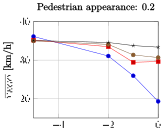

In [77]:

# evaluation based on actionloncost and keepvelocityreward
folder_name = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem_longitudinal2"
probability_pedestrian_births = [0.05 0.2] 
(plots_vmean_pomdp_ebs, plots_collision_pomdp_ebs, plots_interventions_pomdp_ebs) = generateRewardPlots(folder_name, probability_pedestrian_births)

    
folder_name = "PedestrianAvoidancePOMDP_longitudinal2"
probability_pedestrian_births = [0.2 0.4] 
(plots_vmean_pomdp, plots_collision_pomdp, tmp) = generateRewardPlots(folder_name, probability_pedestrian_births)

plots_vmean_pomdp[1]

┌ Warning: performance_reward_action.pdf already exists, overwriting!
└ @ TikzPictures /home/xubuntu/.julia/packages/TikzPictures/Og6d3/src/TikzPictures.jl:251


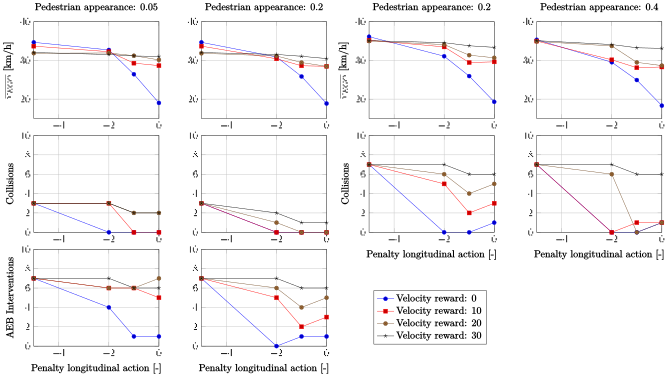

In [78]:
plot_reward = GroupPlot(4, 3, groupStyle = "horizontal sep = 1.5cm, vertical sep = 0.6cm")
push!(plot_reward, plots_vmean_pomdp_ebs[1])
push!(plot_reward, plots_vmean_pomdp_ebs[2])
push!(plot_reward, plots_vmean_pomdp[1])
push!(plot_reward, plots_vmean_pomdp[2])
push!(plot_reward, plots_collision_pomdp_ebs[1])
push!(plot_reward, plots_collision_pomdp_ebs[2])
push!(plot_reward, plots_collision_pomdp[1])
push!(plot_reward, plots_collision_pomdp[2])
push!(plot_reward, plots_interventions_pomdp_ebs[1])
push!(plot_reward, plots_interventions_pomdp_ebs[2])

PGFPlots.save(string("performance_reward_action.pdf"), plot_reward)
plot_reward

In [79]:
# POMDP
folder_name = "PedestrianAvoidancePOMDP_longitudinal2"
probability_pedestrian_births = [0.2 0.3 0.4] 

actionloncost = [0., -1., -2., -5.]
keepvelocityreward = [0., 10., 20., 30., 40.]

results = readResults(folder_name)

plot_pomdp_config = PGFPlots.Linear[]
for p_birth in probability_pedestrian_births
    id_matrix = zeros(Int64, length(actionloncost), length(keepvelocityreward))
    for i=1:length(results)
        result = results[i]
        if result.probability_pedestrian_birth == p_birth
            id_action_lon_cost = findall(x->x == result.action_lon_cost, actionloncost)
            id_keep_velocity_reward = findall(x->x == result.keep_velocity_reward, keepvelocityreward )
            id_matrix[id_action_lon_cost[1],id_keep_velocity_reward[1]] = i 
        end
    end

    for i = 1:length(keepvelocityreward[1:end-4])
        sum_collisions = Float64[]
        v_mean = Float64[]
        for id in id_matrix[:,i]
            push!(sum_collisions, results[id].sum_collisions)
            push!(v_mean, results[id].v_mean)
        end

        p_collision = PGFPlots.Linear(v_mean*3.6, sum_collisions, style="thick", #=style="red", =#
                        legendentry=string("POMDP, Pedestrian appearance: ", p_birth)) 
        push!(plot_pomdp_config, p_collision)
    end
end



┌ Warning: overview_collision_velocity.pdf already exists, overwriting!
└ @ TikzPictures /home/xubuntu/.julia/packages/TikzPictures/Og6d3/src/TikzPictures.jl:251


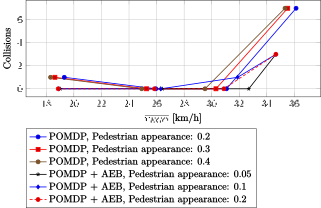

In [80]:
# POMDP + EBS
folder_name = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem_longitudinal2"
probability_pedestrian_births = [0.05 0.1 0.2] 

actionloncost = [0., -1., -2., -5.]
keepvelocityreward = [0., 10., 20., 30., 40.]

results = readResults(folder_name)

plot_pomdp_ebs_config = PGFPlots.Linear[]
for p_birth in probability_pedestrian_births
    id_matrix = zeros(Int64, length(actionloncost), length(keepvelocityreward))
    for i=1:length(results)
        result = results[i]
        if result.probability_pedestrian_birth == p_birth
            id_action_lon_cost = findall(x->x == result.action_lon_cost, actionloncost)
            id_keep_velocity_reward = findall(x->x == result.keep_velocity_reward, keepvelocityreward )
            id_matrix[id_action_lon_cost[1],id_keep_velocity_reward[1]] = i 
        end
    end

    for i = 1:length(keepvelocityreward[1:end-4])
        sum_collisions = Float64[]
        v_mean = Float64[]
        for id in id_matrix[:,i]
            push!(sum_collisions, results[id].sum_collisions)
            push!(v_mean, results[id].v_mean)
        end

        p_collision = PGFPlots.Linear(v_mean*3.6, sum_collisions, style="thick", #= style="blue", =#
            legendentry=string("POMDP + AEB, Pedestrian appearance: ", p_birth)) 
        push!(plot_pomdp_ebs_config, p_collision)
    end
end



plot_collision_velocity = PGFPlots.Axis(style="width=12cm, height=5cm, grid=both", legendPos="south west", 
        #=title="Configurations for POMDP and POMDP + EBS",  =# 
        xlabel=L"$\overline{v_{EGO}}$ [km/h]", ylabel="Collisions")

for i = 1:length(plot_pomdp_config)
    push!(plot_collision_velocity, plot_pomdp_config[i])
end

for i = 1:length(plot_pomdp_ebs_config)
    push!(plot_collision_velocity, plot_pomdp_ebs_config[i])
end


plot_collision_velocity.legendStyle = "{at={(0.0, -1.15)}}"

PGFPlots.save(string("overview_collision_velocity.pdf"), plot_collision_velocity)
plot_collision_velocity

┌ Warning: overview_es_interventions_probabilityPedestrianAvoidancePOMDP_EmergencyBrakingSystem_longitudinal2.pdf already exists, overwriting!
└ @ TikzPictures /home/xubuntu/.julia/packages/TikzPictures/Og6d3/src/TikzPictures.jl:251


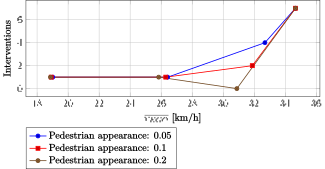

In [84]:
# Emergency Brake Interventions

using Plots
pgfplots()

folder_name = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem_longitudinal2"
probability_pedestrian_births = [0.05 0.1 0.2] 

actionloncost = [0., -1., -2., -5.]
keepvelocityreward = [0., 10., 20., 30., 40.]

results = readResults(folder_name)


plot_es_intervention_velocity = PGFPlots.Axis(style="width=12cm, height=5cm, grid=both", legendPos="south west", 
        #=title="Configurations for POMDP Planner + EBS",  =#
        xlabel=L"$\overline{v_{EGO}}$ [km/h]", ylabel="Interventions")

for p_birth in probability_pedestrian_births
    id_matrix = zeros(Int64, length(actionloncost), length(keepvelocityreward))
    for i=1:length(results)
        result = results[i]
        if result.probability_pedestrian_birth == p_birth
            id_action_lon_cost = findall(x->x == result.action_lon_cost, actionloncost)
            id_keep_velocity_reward = findall(x->x == result.keep_velocity_reward, keepvelocityreward )
            id_matrix[id_action_lon_cost[1],id_keep_velocity_reward[1]] = i 
        end
    end

    for i = 1:length(keepvelocityreward[1:end-4])
        sum_collisions = Float64[]
        sum_emergency_brake_interventions = Float64[]
        dv = []
        v_mean = Float64[]
        a_mean = []
        a_jerk = []
        a_min = []
        for id in id_matrix[:,i]
            #println(id)
            push!(sum_collisions, results[id].sum_collisions)
            push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
            push!(dv, results[id].dv)  
            push!(v_mean, results[id].v_mean)
            push!(a_mean, results[id].a_mean)
            push!(a_jerk, results[id].a_jerk)
            push!(a_min, results[id].a_min)   
        end


        #p_collision = PGFPlots.Linear(actionloncost, sum_collisions, style="red", legendentry=string("Collisions / Velocity reward: ", Int32(keepvelocityreward[i])))

        p_collision = PGFPlots.Linear(v_mean*3.6, sum_emergency_brake_interventions, style="thick", legendentry=string("Pedestrian appearance: ", p_birth))
        push!(plot_es_intervention_velocity, p_collision)

    end
end

plot_es_intervention_velocity.legendStyle = "{at={(0.0, -0.75)}}"

PGFPlots.save(string("overview_es_interventions_probability", folder_name, ".pdf"), plot_es_intervention_velocity)
plot_es_intervention_velocity

┌ Warning: overview_pomdp_configuration.pdf already exists, overwriting!
└ @ TikzPictures /home/xubuntu/.julia/packages/TikzPictures/Og6d3/src/TikzPictures.jl:251


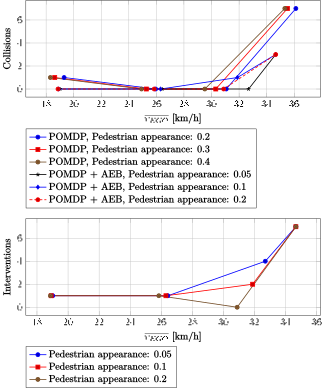

In [85]:
g = GroupPlot(1, 2, groupStyle = "horizontal sep = 0cm, vertical sep = 4.3cm")
push!(g, plot_collision_velocity)
push!(g, plot_es_intervention_velocity)
PGFPlots.save("overview_pomdp_configuration.pdf", g)
g